In [1]:
import parmed as pmd
import numpy as np
import os
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.colors import colorConverter
import seaborn as sns

%load_ext autoreload
%autoreload 2
%load_ext blackcellmagic
%matplotlib inline

/home/dslochower/data/applications/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/dslochower/data/applications/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/dslochower/data/applications/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
from adjustText import adjust_text
import plotting

In [3]:
smirnoff = pmd.load_file("systems/a-bam-p/smirnoff/a000/hg.prmtop")
smirnoff = smirnoff[":MGO"]

In [4]:
bgbg_tip3p = pmd.load_file("systems/a-bam-p/bgbg-tip3p/hg.topo")
bgbg_tip3p = bgbg_tip3p[":MGO"]

In [5]:
bg2bg2_tip3p = pmd.load_file("systems/a-bam-p/bg2bg2-tip3p/vac.topo")
bg2bg2_tip3p = bg2bg2_tip3p[":MGO"]

In [6]:
def scatter_lj(df, x, y, xlabel, ylabel, lower_lim, upper_lim, highlight_color, name, adjust=False):
    fig, ax = plt.subplots(1, figsize=(6 * 1.2, 6))
    text = []
    
    labeled_df = pd.DataFrame()
    for i, j in zip(df[x], df[y]):
        # Find rows matching this value...
        i = np.round(i, 2)
        j = np.round(j, 2)

        tmp = df[(np.round(df[x], 2) == i) & (np.round(df[y], 2) == j)]
        names = tmp.name
        
        
        labeled_df = labeled_df.append(
        pd.DataFrame(
            {
                "i": i,
                "j": j,
                "names": ','.join(names),
                
            },
            index=[0],
        ),
        ignore_index=True,
    )
        
    labeled_df.drop_duplicates(inplace=True)
    for index, row in labeled_df.iterrows():
        if abs(row.i - row.j) > 0.1 * row.i:
            ax.scatter(
                row.i,
                row.j,
                s=80,
                edgecolor="none",
                lw=0.2,
                color="r",
                zorder=2,
            )
            text.append(plt.text(row.i, row.j, f"{row.names}", 
                                 color="r", size=14))
        else:
            ax.scatter(
                row.i,
                row.j,
                s=80,
                edgecolor="none",
                lw=0.2,
                color = "0.5"
                
            )

    ax.plot([-500, 500], [-500, 500], ls="-", c="0.3", zorder=-1, lw="0.5")
    ax.set_ylim([lower_lim, upper_lim])
    ax.set_xlim([lower_lim, upper_lim])

    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    
    if adjust:
        adjust_text(text, expand_points=(2, 2), arrowprops=dict(arrowstyle="-", color="r"))

    fig.savefig(f"figures/{name}.pdf", bbox_inches="tight")
    fig.savefig(f"figures/{name}.svg", bbox_inches="tight")

In [7]:
def scatter_bond(df, x, y, xlabel, ylabel, lower_lim, upper_lim, highlight_color, name, adjust=False):
    fig, ax = plt.subplots(1, figsize=(6 * 1.2, 6))
    text = []
    
    
    labeled_df = pd.DataFrame()
    for i, j in zip(df[x], df[y]):
        # Find rows matching this value...
        i = np.round(i, 2)
        j = np.round(j, 2)
        
        
        tmp = df[(np.round(df[x], 2) == i) & (np.round(df[y], 2) == j)]
        atom1s = tmp.atom1
        atom2s = tmp.atom2
        names = [f"{i}-{j}" for i, j in zip(atom1s, atom2s)]        
            
        labeled_df = labeled_df.append(
        pd.DataFrame(
            {
                "i": i,
                "j": j,
                "names": ','.join(names),
                
            },
            index=[0],
        ),
        ignore_index=True,
    )
        
    labeled_df.drop_duplicates(inplace=True)
    
    
    print(labeled_df)
    
    for index, row in labeled_df.iterrows():
        if abs(row.i - row.j) > 0.1 * row.i:
            ax.scatter(
                row.i,
                row.j,
                s=80,
                edgecolor="none",
                lw=0.2,
                color="r",
                zorder=2,
            )
            text.append(plt.text(row.i, row.j, f"{row.names}", 
                                 color="r", size=14))
        else:
            ax.scatter(
                row.i,
                row.j,
                s=80,
                edgecolor="none",
                lw=0.2,
                color = "0.5"
                
            )
    
    ax.plot([-500, 1000], [-500, 1000], ls="-", c="0.3", zorder=-1, lw="0.5")
    ax.set_ylim([lower_lim, upper_lim])
    ax.set_xlim([lower_lim, upper_lim])

    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    
    if adjust:
        adjust_text(text, expand_points=(2, 2), arrowprops=dict(arrowstyle="-", color="k"))

    fig.savefig(f"figures/{name}.pdf", bbox_inches="tight")
    fig.savefig(f"figures/{name}.svg", bbox_inches="tight")

In [32]:
from parameter_plots import scatter_angle

In [8]:
smirnoff_lj = pd.DataFrame()

for atom in smirnoff.atoms:

    smirnoff_lj = smirnoff_lj.append(
        pd.DataFrame(
            {
                "name": atom.name,
                "type": atom.type,
                "epsilon": atom.epsilon,
                "sigma": atom.sigma,
                
            },
            index=[0],
        ),
        ignore_index=True,
    )


bgbg_tip3p_lj = pd.DataFrame()
for atom in bgbg_tip3p.atoms:

    bgbg_tip3p_lj = bgbg_tip3p_lj.append(
        pd.DataFrame(
            {
                "name": atom.name,
                "type": atom.type,
                "epsilon": atom.epsilon,
                "sigma": atom.sigma,
                
            },
            index=[0],
        ),
        ignore_index=True,
    )

bg2bg2_tip3p_lj = pd.DataFrame()
for atom in bg2bg2_tip3p.atoms:

    bg2bg2_tip3p_lj = bg2bg2_tip3p_lj.append(
        pd.DataFrame(
            {
                "name": atom.name,
                "type": atom.type,
                "epsilon": atom.epsilon,
                "sigma": atom.sigma,
                
            },
            index=[0],
        ),
        ignore_index=True,
    )

In [9]:
df = smirnoff_lj.merge(bgbg_tip3p_lj, on="name", suffixes=("_smirnoff", "_bgbg_tip3p"),
                      how="outer")

In [10]:
# df.drop_duplicates(inplace=True, subset=["epsilon_smirnoff", "sigma_smirnoff", "epsilon_bgbg_tip3p", "sigma_bgbg_tip3p"])
df.drop_duplicates(inplace=True, subset=["name"])


In [11]:
df.head()

,name,type_smirnoff,epsilon_smirnoff,sigma_smirnoff,type_bgbg_tip3p,epsilon_bgbg_tip3p,sigma_bgbg_tip3p
0,C1,1,0.1094,3.399670,c3,0.1094,3.399670
36,H1,2,0.0157,2.293173,h2,0.0157,2.293173
72,O1,3,0.1700,3.000012,os,0.1700,3.000012
108,C2,4,0.1094,3.399670,c3,0.1094,3.399670
144,H2,5,0.0157,2.471353,h1,0.0157,2.471353


/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (48) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (46) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (48) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/mat

/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (109) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (111) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (108) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/

/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (55) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (101) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (112) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/m

/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (116) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))


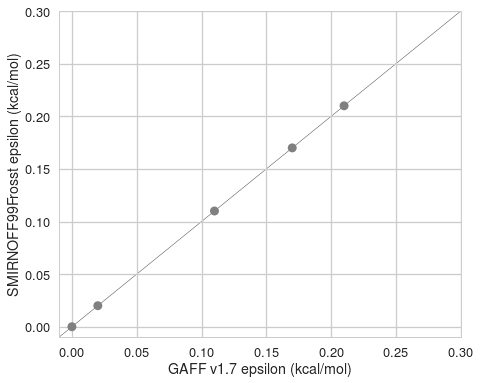

In [12]:
scatter_lj(df, "epsilon_bgbg_tip3p", "epsilon_smirnoff", 
           "GAFF v1.7 epsilon (kcal/mol)", 
           "SMIRNOFF99Frosst epsilon (kcal/mol)", 
        -0.01, 0.3, "r", "SMIRNOFF99Frosst-vs-GAFF-v1.7-epsilon", adjust=True)

/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (48) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (46) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (48) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/mat

/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (57) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (57) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (114) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/ma

/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (83) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (77) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (73) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/mat

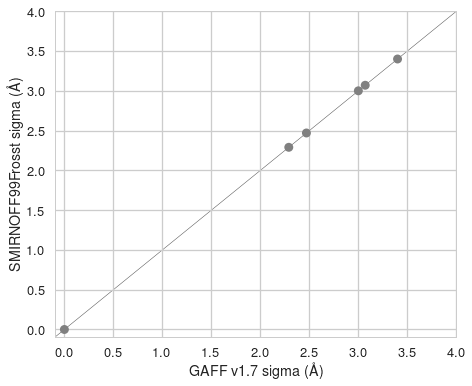

In [13]:
scatter_lj(df, "sigma_bgbg_tip3p", "sigma_smirnoff", 
           "GAFF v1.7 sigma (\AA)", "SMIRNOFF99Frosst sigma (\AA)", 
           -0.1, 4, "r", 
        "SMIRNOFF99Frosst-vs-GAFF-v1.7-sigma")


/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (48) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (46) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (48) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/mat

/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (111) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (108) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (41) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/m

/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (101) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (112) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (115) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/

/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (44) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (54) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (48) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/mat

/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (79) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (57) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (57) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/mat

/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (97) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (40) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (197) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/ma

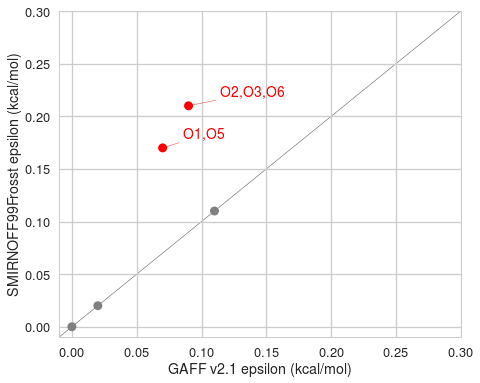

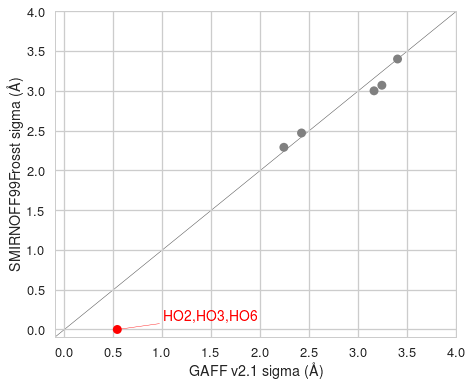

In [14]:
df = smirnoff_lj.merge(bg2bg2_tip3p_lj, on="name", suffixes=("_smirnoff", "_bg2bg2_tip3p"),
                      how="outer")
# df.drop_duplicates(inplace=True, subset=["epsilon_smirnoff", "sigma_smirnoff", 
#                                          "epsilon_bg2bg2_tip3p", "sigma_bg2bg2_tip3p"])
df.drop_duplicates(inplace=True, subset=["name"])


scatter_lj(df, "epsilon_bg2bg2_tip3p", "epsilon_smirnoff", 
           "GAFF v2.1 epsilon (kcal/mol)", "SMIRNOFF99Frosst epsilon (kcal/mol)", 
        -0.01, 0.3, "r", "SMIRNOFF99Frosst-vs-GAFF-v2.1-epsilon", adjust=True)

scatter_lj(df, "sigma_bg2bg2_tip3p", "sigma_smirnoff", 
           "GAFF v2.1 sigma (\AA)", "SMIRNOFF99Frosst sigma (\AA)", -0.1, 4, "r", 
        "SMIRNOFF99Frosst-vs-GAFF-v2.1-sigma", adjust=True)


In [15]:
df[(np.round(df.epsilon_bg2bg2_tip3p, 2) == x) & (np.round(df.epsilon_smirnoff, 2) == y)]

NameError: name 'x' is not defined

# Bonds

In [16]:
def find_bonds(structure):
    df = pd.DataFrame()
    for atom in structure.atoms:
        for bond in atom.bonds:
            df = df.append(
                pd.DataFrame(
                    {
                        "atom1": bond.atom1.name,
                        "atom2": bond.atom2.name,
                        "atom1_type": bond.atom1.type,
                        "atom2_type": bond.atom2.type,
                        "req": bond.type.req,
                        "k": bond.type.k,
                    },
                    index=[0],
                ),
                ignore_index=True,
            )
    return df


In [17]:
smirnoff_bonds = find_bonds(smirnoff)
bgbg_tip3p_bonds = find_bonds(bgbg_tip3p)
bg2bg2_tip3p_bonds = find_bonds(bg2bg2_tip3p)


In [18]:
df = smirnoff_bonds.merge(bgbg_tip3p_bonds, on=["atom1", "atom2"], suffixes=("_smirnoff", "_bgbg_tip3p"),
                         how="outer")

In [19]:
# df.drop_duplicates(inplace=True, subset=["k_smirnoff", "req_smirnoff", "k_bgbg_tip3p", "req_bgbg_tip3p"])
df.drop_duplicates(inplace=True, subset=["atom1", "atom2"])

In [20]:
df[["k_smirnoff", "k_bgbg_tip3p"]].min()
df[["k_smirnoff", "k_bgbg_tip3p"]].max()

k_smirnoff      553.0
k_bgbg_tip3p    369.6
dtype: float64

       i      j                                  names
0  301.5  320.0          C1-O1,C1-O5,O1-C4,C4-O1,C5-O5
1  303.1  310.0          C1-C2,C2-C3,C3-C4,C4-C5,C5-C6
3  326.4  340.0                                  C1-H1
5  314.1  320.0                      C2-O2,C3-O3,C6-O6
7  335.9  340.0  C2-H2,C3-H3,C4-H4,C5-H5,C6-H61,C6-H62
8  369.6  553.0                   O2-HO2,O3-HO3,O6-HO6


/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (51) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (48) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (48) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/mat

/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (197) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (50) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (41) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/ma

/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (53) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (52) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (71) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/mat

/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (41) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (83) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (77) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/mat

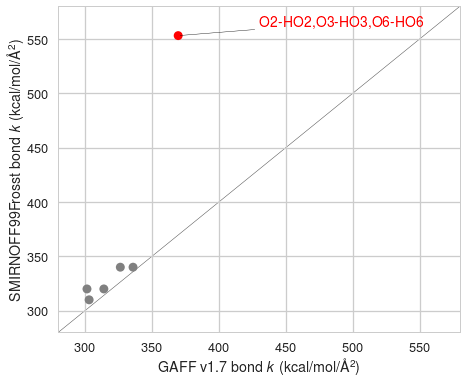

In [21]:
scatter_bond(df, "k_bgbg_tip3p", "k_smirnoff", 
             r"GAFF v1.7 bond $k$ (kcal/mol/\AA$^2$)", 
             r"SMIRNOFF99Frosst bond $k$ (kcal/mol/\AA$^2$)", 
             280, 580, "r", 
        "SMIRNOFF99Frosst-vs-GAFF-v1.7-bond-k", adjust=True)


In [22]:
df[["req_smirnoff", "req_bgbg_tip3p"]].min()

req_smirnoff      0.960
req_bgbg_tip3p    0.974
dtype: float64

In [23]:
df[["req_smirnoff", "req_bgbg_tip3p"]].max()

req_smirnoff      1.526
req_bgbg_tip3p    1.535
dtype: float64

      i     j                                  names
0  1.44  1.37          C1-O1,C1-O5,O1-C4,C4-O1,C5-O5
1  1.54  1.53          C1-C2,C2-C3,C3-C4,C4-C5,C5-C6
3  1.10  1.09                                  C1-H1
5  1.43  1.41                      C2-O2,C3-O3,C6-O6
7  1.09  1.09  C2-H2,C3-H3,C4-H4,C5-H5,C6-H61,C6-H62
8  0.97  0.96                   O2-HO2,O3-HO3,O6-HO6


/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (48) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (46) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (56) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/mat

/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (79) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (114) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (115) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/m

/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (41) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (83) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (77) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/mat

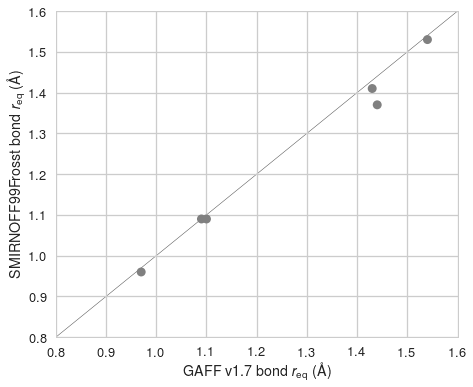

In [24]:
scatter_bond(df, "req_bgbg_tip3p", "req_smirnoff", 
             r"GAFF v1.7 bond $r_\text{eq}$ (\AA)", 
             r"SMIRNOFF99Frosst bond $r_\text{eq}$ (\AA)", 0.8, 1.6, "r", 
        "SMIRNOFF99Frosst-vs-GAFF-v1.7-bond-req", adjust=True)


       i      j                                  names
0  284.8  320.0          C1-O1,C1-O5,O1-C4,C4-O1,C5-O5
1  232.5  310.0          C1-C2,C2-C3,C3-C4,C4-C5,C5-C6
3  377.3  340.0                                  C1-H1
5  293.4  320.0                      C2-O2,C3-O3,C6-O6
7  375.9  340.0  C2-H2,C3-H3,C4-H4,C5-H5,C6-H61,C6-H62
8  563.5  553.0                   O2-HO2,O3-HO3,O6-HO6


/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (51) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (48) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (48) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/mat

/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (41) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (83) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (77) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/mat

/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (51) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (48) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (48) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/mat

/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (50) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (41) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (83) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/mat

      i     j                                        names
0  1.43  1.37                C1-O1,C1-O5,O1-C4,C4-O1,C5-O5
1  1.54  1.53                C1-C2,C2-C3,C3-C4,C4-C5,C5-C6
3  1.10  1.09  C1-H1,C2-H2,C3-H3,C4-H4,C5-H5,C6-H61,C6-H62
5  1.42  1.41                            C2-O2,C3-O3,C6-O6
8  0.97  0.96                         O2-HO2,O3-HO3,O6-HO6


/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (48) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (46) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (56) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/mat

/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (78) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (79) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (114) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/ma

/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (113) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (40) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (197) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/m

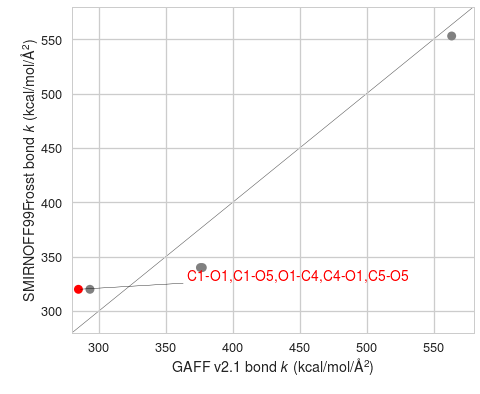

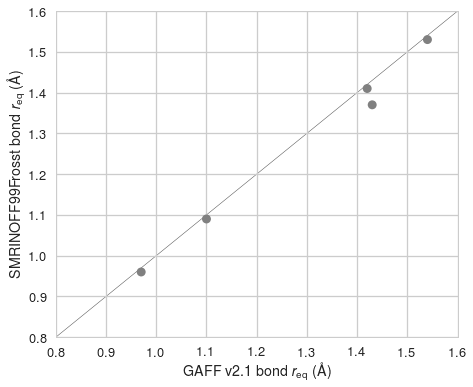

In [25]:
df = bg2bg2_tip3p_bonds.merge(smirnoff_bonds, on=["atom1", "atom2"], suffixes=("_bg2bg2_tip3p", "_smirnoff"),
                         how="outer")
df.drop_duplicates(inplace=True, subset=["atom1", "atom2"])


scatter_bond(df, "k_bg2bg2_tip3p", "k_smirnoff", r"GAFF v2.1 bond $k$ (kcal/mol/\AA$^2$)", 
             r"SMIRNOFF99Frosst bond $k$ (kcal/mol/\AA$^2$)", 280, 580, "r", 
        "SMIRNOFF99Frosst-vs-GAFF-v2.1-bond-k", adjust=True)
scatter_bond(df, "req_bg2bg2_tip3p", "req_smirnoff", r"GAFF v2.1 bond $r_\text{eq}$ (\AA)", 
             r"SMRINOFF99Frosst bond $r_\text{eq}$ (\AA)", 0.8, 1.6, "r", 
        "SMIRNOFF99Frosst-vs-GAFF-v2.1-bond-req", adjust=True)


# Angles

In [26]:
def find_angles(structure):
    df = pd.DataFrame()
    for atom in structure.atoms:
        for angle in atom.angles:
            df = df.append(
                pd.DataFrame(
                    {
                        "atom1": angle.atom1.name,
                        "atom2": angle.atom2.name,
                        "atom3": angle.atom3.name,
                        "k": angle.type.k,
                        "theta_eq": angle.type.theteq,
                    },
                    index=[0],
                ),
                ignore_index=True,
            )
    return df

In [27]:
smirnoff_angles = find_angles(smirnoff)
bgbg_tip3p_angles = find_angles(bgbg_tip3p)
bg2bg2_tip3p_angles = find_angles(bg2bg2_tip3p)

In [28]:
df = smirnoff_angles.merge(bgbg_tip3p_angles, on=["atom1", "atom2", "atom3"], 
                              suffixes=("_smirnoff", "_bgbg_tip3p"),
                             how="outer")

In [29]:
df.head()

,atom1,atom2,atom3,k_smirnoff,theta_eq_smirnoff,k_bgbg_tip3p,theta_eq_bgbg_tip3p
0,O1,C1,C2,50.0,109.5,67.78,108.420047
1,O1,C1,C2,50.0,109.5,67.78,108.420047
2,O1,C1,C2,50.0,109.5,67.78,108.420047
3,O1,C1,C2,50.0,109.5,67.78,108.420047
4,O1,C1,C2,50.0,109.5,67.78,108.420047


In [30]:
df.drop_duplicates(inplace=True, subset=["atom1", "atom2", "atom3"])

In [60]:
tmp = df.drop(columns=["theta_eq_smirnoff", "theta_eq_bgbg_tip3p"])
tmp = tmp.round(decimals=1)
groups = tmp.groupby(["k_smirnoff", "k_bgbg_tip3p"])

In [61]:
for key, value in groups.groups.items():
    print(tmp.ix[value])

      atom1 atom2 atom3  k_smirnoff  k_bgbg_tip3p
12276   H61    C6   H62        35.0          39.2
     atom1 atom2 atom3  k_smirnoff  k_bgbg_tip3p
2493    H1    C1    C2        50.0          46.0
      atom1 atom2 atom3  k_smirnoff  k_bgbg_tip3p
3141     C1    C2    H2        50.0          46.4
5436     H2    C2    C3        50.0          46.4
5760     C2    C3    H3        50.0          46.4
7389     H3    C3    C4        50.0          46.4
7713     C3    C4    H4        50.0          46.4
9027     H4    C4    C5        50.0          46.4
9360     C4    C5    H5        50.0          46.4
10656    H5    C5    C6        50.0          46.4
10980    C5    C6   H61        50.0          46.4
11304    C5    C6   H62        50.0          46.4
      atom1 atom2 atom3  k_smirnoff  k_bgbg_tip3p
6084     C2    O2   HO2        50.0          47.1
8037     C3    O3   HO3        50.0          47.1
12600    C6    O6   HO6        50.0          47.1
      atom1 atom2 atom3  k_smirnoff  k_bgbg_tip3p
21

/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  from ipykernel import kernelapp as app


Pruning ['O--C--C'] from C--C--O.
Pruning [] from O--C--O.
Pruning ['O--C--C'] from C--C--O.
Pruning [] from C--C--C.
Pruning [] from C--O--C.
Pruning ['H--C--O'] from O--C--H.
Pruning [] from H--C--C.
Pruning ['C--C--H'] from H--C--C.
Pruning [] from H--C--O.
Pruning [] from C--O--H.
Pruning [] from H--C--H.


/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (48) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (50) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (52) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/mat

/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (47) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (114) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (97) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/ma

/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (49) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (71) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (65) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/mat

/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (83) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (77) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (73) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/mat

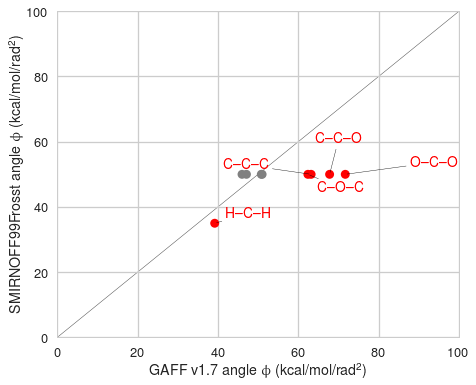

In [33]:
scatter_angle(df, "k_bgbg_tip3p", "k_smirnoff", r"GAFF v1.7 angle $\phi$ (kcal/mol/rad$^2$)", r"SMIRNOFF99Frosst angle $\phi$ (kcal/mol/rad$^2$)", 
        0, 100, "r", 
        "SMIRNOFF99Frosst-vs-GAFF-v1.7-ang-k",
       adjust=True)


Pruning ['O--C--C'] from C--C--O.
Pruning [] from O--C--O.
Pruning ['O--C--C'] from C--C--O.
Pruning [] from C--C--C.
Pruning [] from C--O--C.
Pruning [] from H--C--O.
Pruning [] from H--C--C.
Pruning ['C--C--H'] from H--C--C.
Pruning ['H--C--O'] from O--C--H.
Pruning [] from H--C--O.
Pruning [] from C--O--H.
Pruning [] from H--C--H.


/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (49) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (48) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (48) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/mat

/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (57) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (57) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (114) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/ma

/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (83) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (77) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (73) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/mat

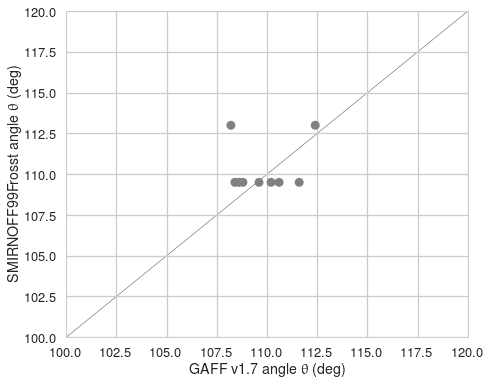

In [62]:
scatter_angle(df, "theta_eq_bgbg_tip3p", "theta_eq_smirnoff", r"GAFF v1.7 angle $\theta$ (deg)", r"SMIRNOFF99Frosst angle $\theta$ (deg)", 
        100, 120, "r", 
        "SMIRNOFF99Frosst-vs-GAFF-v1.7-ang-theta",
       adjust=True)


Pruning ['O--C--C'] from C--C--O.
Pruning [] from O--C--O.
Pruning ['O--C--C'] from C--C--O.
Pruning [] from C--C--C.
Pruning [] from C--O--C.
Pruning ['H--C--O'] from O--C--H.
Pruning [] from H--C--C.
Pruning ['C--C--H'] from H--C--C.
Pruning [] from H--C--O.
Pruning [] from C--O--H.
Pruning [] from H--C--H.


/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (48) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (50) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (52) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/mat

/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (114) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (97) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (100) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/m

/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (46) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (97) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (110) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/ma

/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (115) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (115) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (116) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/

Pruning ['O--C--C'] from C--C--O.
Pruning [] from O--C--O.
Pruning ['O--C--C'] from C--C--O.
Pruning [] from C--C--C.
Pruning [] from C--O--C.
Pruning [] from H--C--O.
Pruning [] from H--C--C.
Pruning ['C--C--H'] from H--C--C.
Pruning ['H--C--O'] from O--C--H.
Pruning [] from H--C--O.
Pruning [] from C--O--H.
Pruning [] from H--C--H.


/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (49) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (48) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (48) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/mat

/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (57) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (57) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (114) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/ma

/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (83) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (77) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (73) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/helvetic/uhvr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/mat

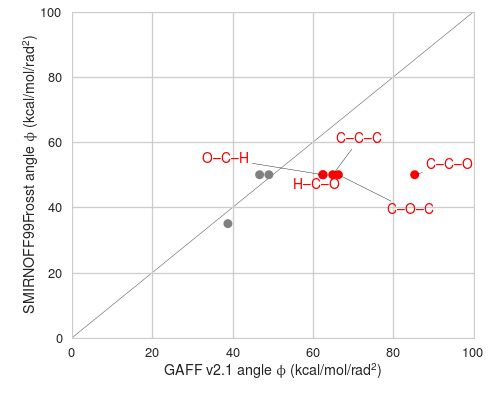

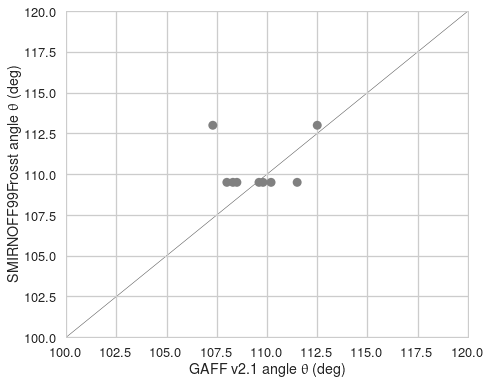

In [63]:
df = smirnoff_angles.merge(bg2bg2_tip3p_angles, on=["atom1", "atom2", "atom3"], 
                              suffixes=("_smirnoff", "_bg2bg2_tip3p"),
                             how="outer")
df.drop_duplicates(inplace=True, subset=["atom1", "atom2", "atom3"])

scatter_angle(df, "k_bg2bg2_tip3p", "k_smirnoff", r"GAFF v2.1 angle $\phi$ (kcal/mol/rad$^2$)", r"SMIRNOFF99Frosst angle $\phi$ (kcal/mol/rad$^2$)", 
        0, 100, "r", 
        "SMIRNOFF99Frosst-vs-GAFF-v2.1-ang-k",
       adjust=True)
scatter_angle(df, "theta_eq_bg2bg2_tip3p", "theta_eq_smirnoff", r"GAFF v2.1 angle $\theta$ (deg)", r"SMIRNOFF99Frosst angle $\theta$ (deg)", 
        100, 120, "r", 
        "SMIRNOFF99Frosst-vs-GAFF-v2.1-ang-theta",
       adjust=True)


# Dihedrals

In [274]:
def find_dihedrals(structure):
    df = pd.DataFrame()
    for atom in structure.atoms:
        for dihedral in atom.dihedrals:
            df = df.append(
                pd.DataFrame(
                    {
                        "atom1": dihedral.atom1.name,
                        "atom2": dihedral.atom2.name,
                        "atom3": dihedral.atom3.name,
                        "atom4": dihedral.atom4.name,
                        "phi_k": dihedral.type.phi_k,
                        "per": dihedral.type.per,
                        "phase": dihedral.type.phase,
                    },
                    index=[0],
                ),
                ignore_index=True,
            )
    return df


In [275]:
smirnoff_dihedrals = find_dihedrals(smirnoff)
bgbg_tip3p_dihedrals = find_dihedrals(bgbg_tip3p)
bg2bg2_tip3p_dihedrals = find_dihedrals(bg2bg2_tip3p)